## BIO322 MINI PROJECT A (Thomas Castiglione)


**1. Exploration**


We first load and take a look at the training data:

In [1]:
data<-read.csv(file.path("..", "data","training_data.csv"))

,Intensity,VALENCE.PLEASANTNESS,SWEETORSOUR,V2,V3,V4,V5,V6,V7,V8,...,V11778,V11779,V11780,V11781,V11782,V11783,V11784,V11785,V11786,V11787
,<chr>,<int>,<lgl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,high,11,FALSE,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,high,75,TRUE,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,low,62,TRUE,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,low,39,FALSE,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
5,low,55,FALSE,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
6,low,47,FALSE,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


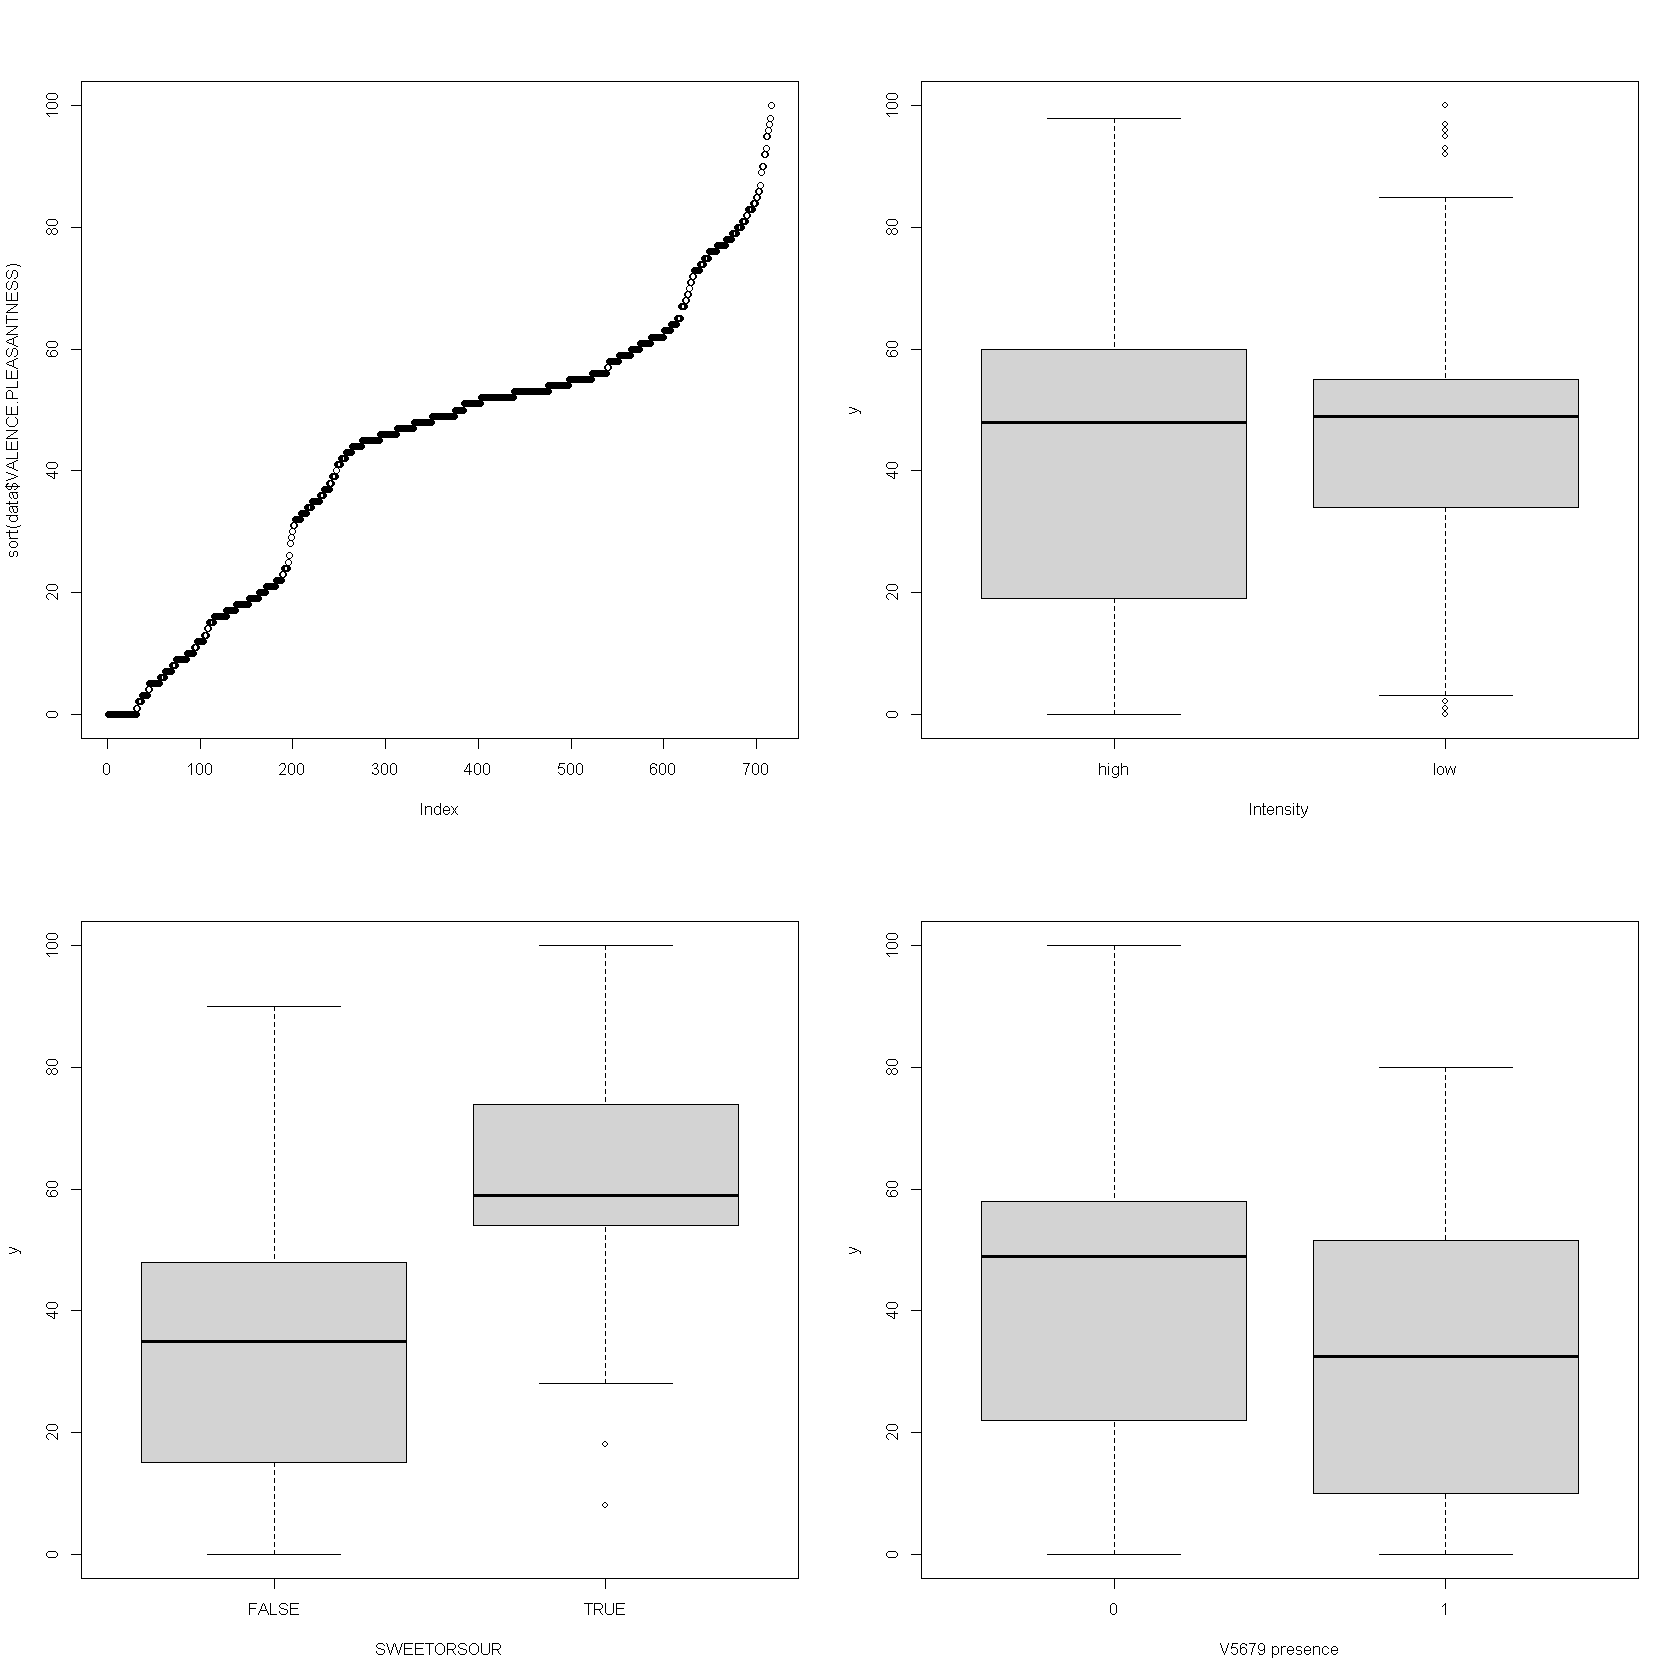

In [2]:
head(data)
options(repr.plot.width=14, repr.plot.height=14)
par(mfrow=c(2,2))
plot(sort(data$VALENCE.PLEASANTNESS))
plot(as.factor(data$Intensity),data$VALENCE.PLEASANTNESS, xlab='Intensity')
plot(as.factor(data$SWEETORSOUR),data$VALENCE.PLEASANTNESS,xlab='SWEETORSOUR')
plot(as.factor(data$V5679),data$VALENCE.PLEASANTNESS, xlab ='V5679 presence') #arbitrary chosen physiochemical feature.

the data we are interested in is VALENCE.PLEASANTNESS, wich take values between 0 and 100. The objective is to create a model estimating the VALENCE.PLEASANTNESS given the inputs "Intensity, "SWEETORSOUR"(sure?), and V2 to V11787, which represent the presence or not of a corresponding physiochemical feature in the smelled molecule.

In [81]:
#check the means with or without some randomly chosen physiochemical features
mean.chem.presence<-c()
for(col in sample(2:nrow(data),50)){
    idx.presence<-c()
    idx.nonpresence<-c()
    for(i in 1:nrow(data)){
        if(data[col,i]==1){
            idx.presence<-append(idx.presence,i)
        }else{
            idx.nonpresence<-append(idx.nonpresence,i)
        }
    }
    #message("presence mean ",mean(data$VALENCE.PLEASANTNESS[idx.presence]))
    #message("nonpresence mean ",mean(data$VALENCE.PLEASANTNESS[idx.nonpresence]))
}

In [20]:
lin.reg<-lm(data$VALENCE.PLEASANTNESS~data$Intensity,data)
mini.pred<-predict(lin.reg,data)
mini.rss<-mean((mini.pred-data$VALENCE.PLEASANTNESS)^2)
print(mini.rss)

[1] 541.2861


now: start for real, do it right: split the data bt train, CV, test, start the linear models.